# Evaluation Metrics

This project aims to determine if the model trained for predicting churn (in previous project) is a good one.


Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are*

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

Accuracy is 80.34%

## Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [10]:
len(y_val)

1409

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

In [15]:
(y_val == churn_decision).sum()

1132

Number of correct decisions made = 1132

Next, I divide this figure by the total number of customers to get the accuracy

In [14]:
1132/ 1409

0.8034066713981547

In [16]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

Note that tthe decision to predict churn or not churn was 50%. Next, I will confirm if that was actually a good decision (as opposed to 30% or 60% perhaps

In [24]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


It can be seen that 0.50 is indeed the best threshold (0.803). It's slighly more accurate than 0.55, and the threshold steadily declines at other decision scores. It can also be seen on the chart below (the line chart peaks at 0.5).

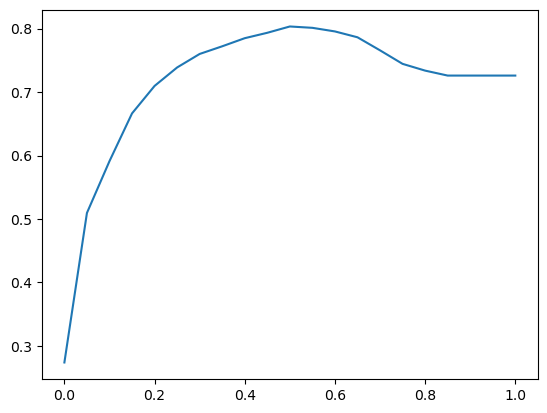

In [21]:
plt.plot(thresholds, scores);

In [25]:
from collections import Counter

In [26]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

This counts the occurrences of `True` and `False` values in the condition `y_pred >= 1.0`. In other words, it is counting how many predictions have a probability greater than or equal to 1.0. The result is a Counter object, and in this case, it shows that there are 1409 instances where the condition is False (customers not churning).

In [27]:
1 - y_val.mean()

0.7260468417317246

This is calculating the complement of the mean value of `y_val`. 
`y_val` contains the actual binary labels for whether customers churned or not (1 or 0). 
The mean of `y_val` represents the proportion of customers who churned (subtracting this mean from 1 gives the proportion of customers who did not churn).

> Accuracy score can be quite misleading (esecially in cases of class imbalance). It usually does not say how good the model is as well.
>
> There are other ways of rating binary classification models (other than accuracy) that are quite useful (especially when talking about problems with class imbalance like the churn prediction).

## Confusion table
- Different types of errors and correct decisions
- Arranging them in a table

In [28]:
actual_positive = (y_val == 1) #correct prediction of customers who churn
actual_negative = (y_val == 0) #correct prediction of customers who did not churn

In [29]:
t = 0.5   #threshold
predict_positive = (y_pred >= t)   #predict positive when above threshold
predict_negative = (y_pred < t)    #predict negative when below threshold

>Next, combine predictions and actual outcomes. Focus is on cases when both predicted and actual positives are `True`. 
>
>(Remember that using the logical operator `and`, both cases have to be true to return a `True`. If one case is true ahile the other is false, it will return a false). 
>
>The `'&'` operator computes the element-wise logically.

In [30]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

*Note Values:*

- TP = 210
- TN = 922
- FP = 101
- FN = 176

In [31]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

Next, normalize the matrix (instead of absolute numbers, make it relative numbers)

In [35]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

*Relative Values:*

- TP = 15%
- TN = 65%
- FP = 8%
- FN = 12%

> Accuracy = 80% (65% + 15%)

## Precision and Recall

In [39]:
#Precision tell us how many positive predictions turned out to be correct (fraction of correct positive predictions)

p = tp / (tp + fp)
p

0.6752411575562701

Precision is 67.5% (these are those who correctly receive the promotional email)

This means that out of all the positive predictions made by the model (instances where it predicted customers would churn), approximately 67.5% of those predictions turned out to be correct. In other words, when the model predicted churn, it was accurate about 67.5% of the time. 

Conversely, about 33% are mistakes (these are people who are not supposed to receive the promotional email but received it anyway).

High precision is desirable, especially in scenarios where the cost of false positives (incorrectly predicting churn) is high. However, it's essential to consider precision along with other metrics like recall, accuracy, and the specific business context to have a comprehensive understanding of the model's performance.

In [42]:
# Recall measures the model's ability to capture all the positive instances. 
# It answers the question: "Out of all the actual positive instances, how many did the model correctly predict?" 
'''High recall indicates that the model is effective at capturing most of the positive instances, 
but it may also include false positives.'''

r = tp / (tp + fn)
r

0.5440414507772021

The recall value of 0.544 means that the model is capturing approximately 54.4% of the customers who are actually churning. In other words, there are instances where the model fails to identify customers who are churning (46%), leading to false negatives.

A higher recall is generally desirable in scenarios where missing positive instances (churn cases in this context) is more critical than having a precise prediction. However, it is important to consider the trade-off between precision and recall, as improving one may negatively impact the other. The specific balance depends on the goals and priorities of the business problem being addressed with the churn prediction model.

> It is clear to see that Accuracy is not the best metric for identifying churning users. Initially, the model seemed to be doing good at an accuracy of 80% but after looking at the precision and recall, we see that we fail to identify 46% of users and actually sent promotional email to 33% of users who we thought would churn but will likely only take advantage of the promotional discount. So, we see that how accuracy can be misleading (especially in cases of class imbalance). It is always good to look at precision and recall as well.

# ROC Curves

## TPR and FRP

A Receiver Operating Characteristic (ROC) curve is a graphical representation that illustrates the performance of a binary classification model at various classification thresholds. It plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) for different threshold values.

- True Positive Rate (Sensitivity): The proportion of actual positive instances correctly identified by the model.

- False Positive Rate (1 - Specificity): The proportion of actual negative instances incorrectly identified as positive by the model.

By varying the classification threshold, the ROC curve shows how sensitivity and specificity trade off against each other. The area under the ROC curve (AUC-ROC) is a commonly used metric to quantify the overall performance of a binary classification model. A higher AUC-ROC indicates better discrimination between positive and negative instances across different thresholds, with a value of 1.0 representing perfect performance.

In [43]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

The TPR value of approximately 0.54 (54%) suggests that the model correctly identified about 54% of the customers who actually churned.

TPR is particularly relevant when the cost of missing positive instances (false negatives) is high. In the context of customer churn, it indicates the effectiveness of the model in capturing customers who are likely to leave.

In [44]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

The FPR value of approximately 0.10 (10%) suggests that the model incorrectly identified about 10% of the customers as churned when they did not actually churn.

FPR is crucial when the cost of falsely identifying negative instances as positive (false positives) is high. In the context of customer churn, it indicates the rate at which the model makes incorrect predictions about customers who are not likely to leave.

> The threshold of 0.5 (50%) returned the values of FPR & TPR above. ROC curve evaluates all the possible thresholds. I will compute them below (using the linspace):

In [45]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [46]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

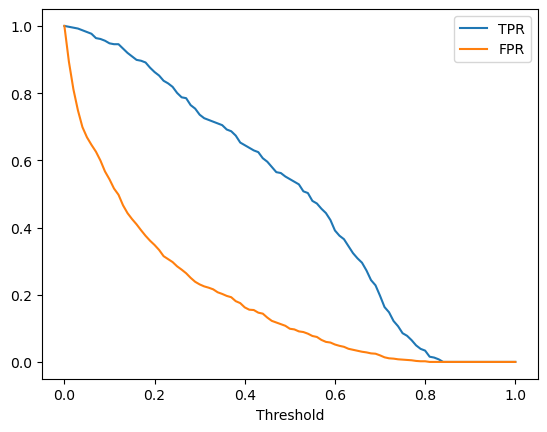

In [54]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.xlabel('Threshold')
plt.legend();

The plot visualizes how TPR and FPR change with varying classification thresholds.

The x-axis represents different threshold values, which are probability thresholds for classifying customers as churned or not churned. These thresholds influence the model's sensitivity and specificity.

At a threshold of 0.0, both the TPR and FPR are 1.0 indicating that the model is classifying all instances as positive (meaning that this model predicts everyone as churning). Therefore, it captures all true positives (TPR = 1.0), but it also incorrectly includes all negatives as positives (as churning), resulting in a FPR of 1.0. 

The TPR and FPR descend at different rates. The FPR goes down faster (we want it to go down as fast as possible; we want to minimize it so we want it to be as low as possible), while for TPR, we want to keep it around 1.0

## Random model

A random model in the context of binary classification makes predictions without any reliance on the input features. It essentially assigns class labels randomly, without considering the data's characteristics. For a balanced dataset, a random model would achieve an accuracy close to 50% by chance. It serves as a baseline comparison for evaluating the performance of more sophisticated models, like those trained on actual patterns in the data (in this case, the TPR & FPR).

In [49]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [50]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [51]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [52]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

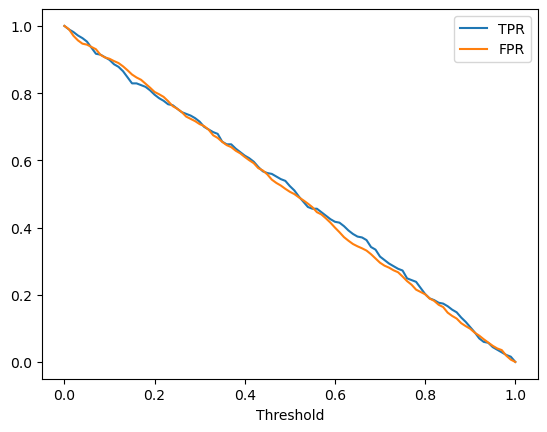

In [55]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.xlabel('Threshold')
plt.legend();

The plot illustrates the Receiver Operating Characteristic (ROC) curve for a random model in the context of customer churn. The True Positive Rate (TPR) and False Positive Rate (FPR) are plotted against different threshold values. In a random model, as the threshold varies, both TPR and FPR change in a nearly linear fashion, descending from 1.0 to 0.0. The curve indicates that the model's ability to correctly identify true positives decreases along with the increase in false positives. 

## Ideal model

An ideal model, in the context of customer churn prediction, would have a Receiver Operating Characteristic (ROC) curve that closely follows the upper-left corner of the plot. This ideal curve would have a True Positive Rate (TPR) of 1.0 (100%) and a False Positive Rate (FPR) of 0.0 (0%) across all possible threshold values. Essentially, the ideal model would be able to perfectly distinguish between customers who are likely to churn and those who are not, with no false positive predictions and a maximized true positive rate.

In [56]:
#counting negative and positive

num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [57]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal #validation set (everything is ordered here)

y_ideal_pred = np.linspace(0, 1, len(y_val)) #create predictions

In [58]:
1 - y_val.mean()

0.7260468417317246

In [59]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [60]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


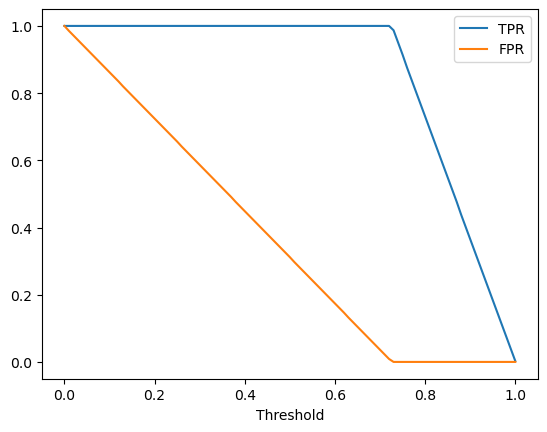

In [61]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.xlabel('Threshold')
plt.legend();

## Putting everything together

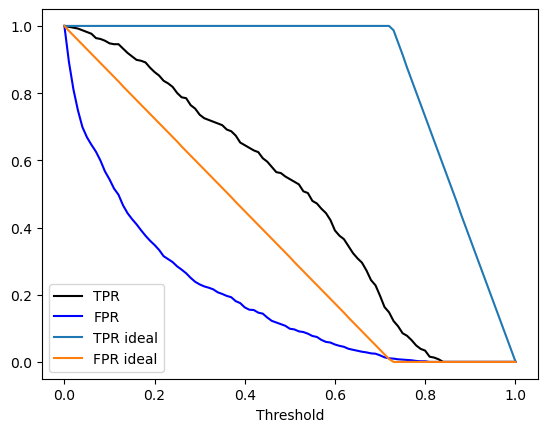

In [62]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.xlabel('Threshold')
plt.legend();

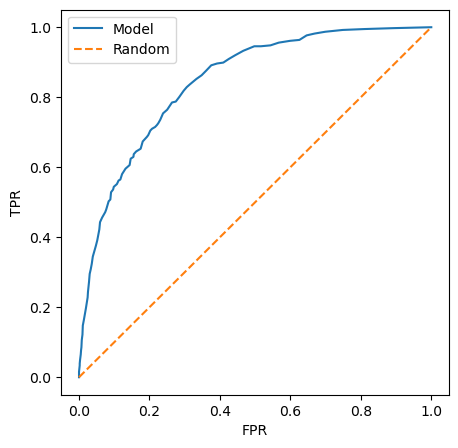

In [91]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

In [65]:
from sklearn.metrics import roc_curve

In [66]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

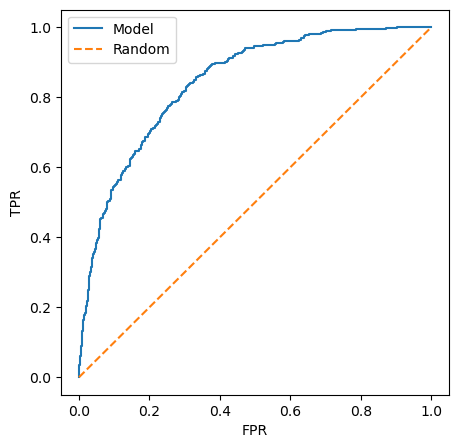

In [92]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

## ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC

In [68]:
from sklearn.metrics import auc

In [69]:
auc(fpr, tpr)

0.8438378435871333

In [70]:
auc(df_scores.fpr, df_scores.tpr)

0.8438163179513671

In [71]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [72]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438378435871333

In [73]:
from sklearn.metrics import roc_auc_score

In [74]:
roc_auc_score(y_val, y_pred)

0.8438378435871333

In [75]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [76]:
import random

In [78]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84444

In [79]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84652

## Cross-Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [80]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [81]:
dv, model = train(df_train, y_train, C=0.001)

In [82]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [84]:
y_pred = predict(df_val, dv, model)

In [85]:
from sklearn.model_selection import KFold

In [86]:
!pip install tqdm

In [87]:
from tqdm.auto import tqdm

In [88]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.006
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [89]:
scores

[0.8423240260300962,
 0.8457220070189378,
 0.8332530604053782,
 0.8319990247489927,
 0.8525462018763139]

In [90]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## Summary

- Metric - a single number that describes the performance of a model
- Accuracy - fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class inbalance
- ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
- K-Fold CV - more reliable estimate for performance (mean + std)